# **Abstractive Text Summarization using LSTM**

### Model presented for Machine Learning Project

#### **Team Members**

- Harisaipravin Sv - 17Pw13
- Karanraj M - 17pw18

- Under the guidance of **Dr. N.Geetha**


*# A neural network is considered to be an effort to mimic human brain actions in a simplified manner. Attention Mechanism is also an attempt to implement the same action of selectively concentrating on a few relevant things, while ignoring others in deep neural networks.*

ATTENTION LAYER DEFINITION

In [1]:
# Attention Layer focusses on one part of the data at a time just like humans, instead of looking all at a time which proved to be forgetfull in RNN

In [2]:
# Keras support Attention Layer Library, We gathered idea from that and tried implementing on our own without going for library
import tensorflow as Tensor_f # Tensorflow supports for Keras
from tensorflow.python.keras.layers import Layer # Keras provide LSTM suppport
from tensorflow.python.keras import backend as Keras_p # Backend Layer
# word count graph for text feedback
import matplotlib.pyplot as plt

# Attention Layer reads word by word just like a human interpretter
# In case of attention Layer All the data is fed through every iteration along with the previous result from the before iteration
# It does this instead of just sending the previous result and thus allowing it to remember much data
class Algo_attention(Layer):
# This is the class from which all layers inherit. A layer is a callable object that takes as input one or more tensors and the outputs one or more tensors.

    def __init__(self, **kwargs): #constructor 
        super(Algo_attention, self).__init__(**kwargs) #avoid referring to the base class explicitly

    # Layers -> “forget gate layer”, “input gate layer”, “output gate layer”
    # Layers involves a *state* (weight variables), defined in the `build()` method.
    def build(self, input_shape): # keras default function to build
        assert isinstance(input_shape, list) # Assert lets you test if a condition in your code returns True, if not, the program will raise an AssertionError
        # Creates the state of the Layer
        # Weighted vector creation for the attention layer to be trained
        # The distribution of the input shape to accomodate every value in vertical, horizontal and Diagonal axis
        self.Xval = self.add_weight(name='Xval', shape=Tensor_f.TensorShape((input_shape[0][2], input_shape[0][2])), trainable=True, initializer='uniform') # horizontal line over matrix
        self.Yval = self.add_weight(name='Yval', shape=Tensor_f.TensorShape((input_shape[1][2], input_shape[0][2])), trainable=True, initializer='uniform') # verrical line over matrix
        self.Zval = self.add_weight(name='Zval', shape=Tensor_f.TensorShape((input_shape[0][2], 1)), trainable=True, initializer='uniform') # Diagonal line, 1 stands for input_shape[2][2]
        super(Algo_attention, self).build(input_shape) # Allows callback within the program instead of creating instance everytime

    # Layer involves *computation*, defined in the `call()` method
    def call(self, inputs, verbose=False): 
        assert type(inputs) == list # For Debugging
        crypt, decrypt = inputs # Encode and Decode value both initialized to input at first
        if verbose:
            print('encoder_out_seq>', crypt.shape)
            print('decoder_out_seq>', decrypt.shape)
        
        # Function to create a tensor data
        def start_func(inputs, hidden_size):
            tempdata= Keras_p.zeros_like(inputs)  # 0 array of input size
            tempdata= Keras_p.sum(tempdata, axis=[1, 2])  #Summing the tempdata with values of first two axes which has data from first 2 LSTM models
            tempdata= Keras_p.expand_dims(tempdata) # Adds the third dimension to the tempdata array
            tempdata= Keras_p.tile(tempdata, [1, hidden_size])  # Creates the tensor of size [1, hidden_size] from the temp data value 
            return tempdata

        # sum function to return list
        def process_func(inputs, states):
            temp = Keras_p.sum(crypt * Keras_p.expand_dims(inputs, -1), axis=1) #sum of values along the axis 1
            return temp, [temp] #returns list

        #Applying formula to the input
        def eprocess_func(inputs, states):
            message = "Input must be of type list".format(states, type(states)) # checks input from process_func
            assert isinstance(states, list) or isinstance(states, tuple), message # for debugging it prints the message

            # Shapeing the input for alying formula
            h_data =  crypt.shape[2] # encoder data 2nd col 
            r_output = Keras_p.reshape(crypt, (-1, h_data)) # reshaping encoder data
            s_length = crypt.shape[1] # encoder data 1st col
            Yval_dot_h = Keras_p.expand_dims(Keras_p.dot(inputs, self.Yval), 1)  # Adds dimension of size Yval
            Xval_dot_s = Keras_p.reshape(Keras_p.dot(r_output, self.Xval), (-1, s_length, h_data)) # multiples two tensors and returns them
            
            # Attenntion layer involves banck and forth checks
            # It iterates the string from first to last and last to first 
            r_model = Keras_p.tanh(Keras_p.reshape(Xval_dot_s + Yval_dot_h, (-1, h_data))) # Element-wise tanh returning the array of size h_data
            keras_d = Keras_p.reshape(Keras_p.dot(r_model, self.Zval), (-1, s_length)) # Multiples the num(r_model) 
            keras_d = Keras_p.softmax(keras_d) # Softmax converts a real vector to a vector of categorical probabilities, cuz max of (a)t is 1
            return keras_d, [keras_d]
        
        tempdata_e = start_func(crypt, crypt.shape[1])  #Tensordata created
        tempdata_c = start_func(crypt, crypt.shape[-1])
        #Iterates over the time dimension of a tensor
        final_t, results, _ = Keras_p.rnn(eprocess_func, decrypt, [tempdata_e],) #Encode RNN
        final_t, c_outputs, _ = Keras_p.rnn(process_func, results, [tempdata_c],) #Decode RNN

        return c_outputs, results

## DATA PREPERATION

In [3]:
from nltk.corpus import stopwords # frequently used words like a, an , the , etc
from tensorflow.keras.callbacks import EarlyStopping # To stop when Model converges
from tensorflow.keras.models import Model # To build a Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed # LSTM Support using keras
from bs4 import BeautifulSoup # Remoeving html tags
from keras.preprocessing.text import Tokenizer  # vectorize a text 
from keras.preprocessing.sequence import pad_sequences # ensure that all sequences in a list have the same size
import warnings # To omit warnings
import numpy as np # NumPy is used for working with arrays
import pandas as pd # Manupulating data with dataframe
import re #regular expressions to be removed
import seaborn as sns
from matplotlib import ticker
import nltk # Library for stowords
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer # allows to tokenize texts
from keras.preprocessing.sequence import pad_sequences # pad_sequences is used to ensure that all sequences in a list have the same length
from sklearn.model_selection import train_test_split as tts # Split arrays or matrices into random train and test subsets from the loaded data

In [4]:
warnings.filterwarnings("ignore") #Ignore unnecessary warnings
pd.set_option("display.max_colwidth", 100) # Panda max_col_width set to 100 as it exceeds in some eror cases

In [5]:
!pip install -U -q PyDrive # Pydrive helps in mouting dataset to collab

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials  #oauth2 support given
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() # prompt to sign in
drive = GoogleDrive(gauth)

In [6]:
file_list = drive.ListFile({'q': "'1VBkB-wHeWPihF1kqS1NfdIm9gmI7F_d3' in parents and trashed=false"}).GetList() # folder_id posted here
for file1 in file_list:
  print('%s -> %s' % (file1['title'], file1['id'])) # List of files in the folder

Amazon_analysis.ipynb -> 1P0SfCU0RhQwDFoUAABqR0DwaEywrHjOG
end_words.txt -> 1Zo4obQw8oAiXFcRrRrWoIkxl65CgXen-
Abstract_Txt_LSTM_Atten.pdf -> 17RcYMzpLQ1aSGdRI6CvELC8kHR6-URhQ
Springer_paper.pdf -> 1GDmNsxbgb38PfuX1FQoVcA62ZkoyC_0Q
Reviews.csv -> 1oFrv0a3Zm3H-ZD20zxXAoqh51Sgr_aVK


In [7]:
f_id=''
drive_file = drive.CreateFile({'id': f_id})
drive_file = drive.CreateFile({'id':'1oFrv0a3Zm3H-ZD20zxXAoqh51Sgr_aVK'}) #file_id to mount
drive_file.GetContentFile('Reviews.csv') #getfile

In [8]:
record=pd.read_csv("Reviews.csv",nrows=100000) #Read file

In [9]:
record.drop_duplicates(subset=['Text'],inplace=True) # Drop duplicates
record.dropna(axis=0,inplace=True) # Drop records with missing data or Null

In [10]:
record.info() #Record Schema

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [11]:
record.head() #Record Preview

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...


Text(0.5, 1.0, 'Score')

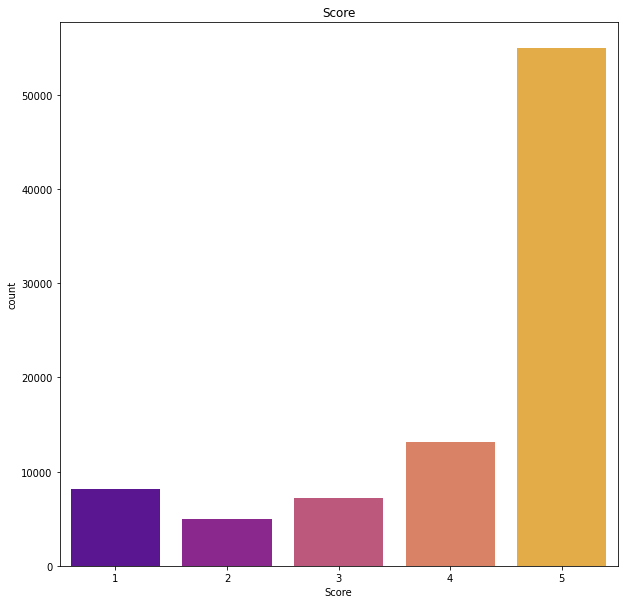

In [12]:
sns.countplot(record['Score'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Score')

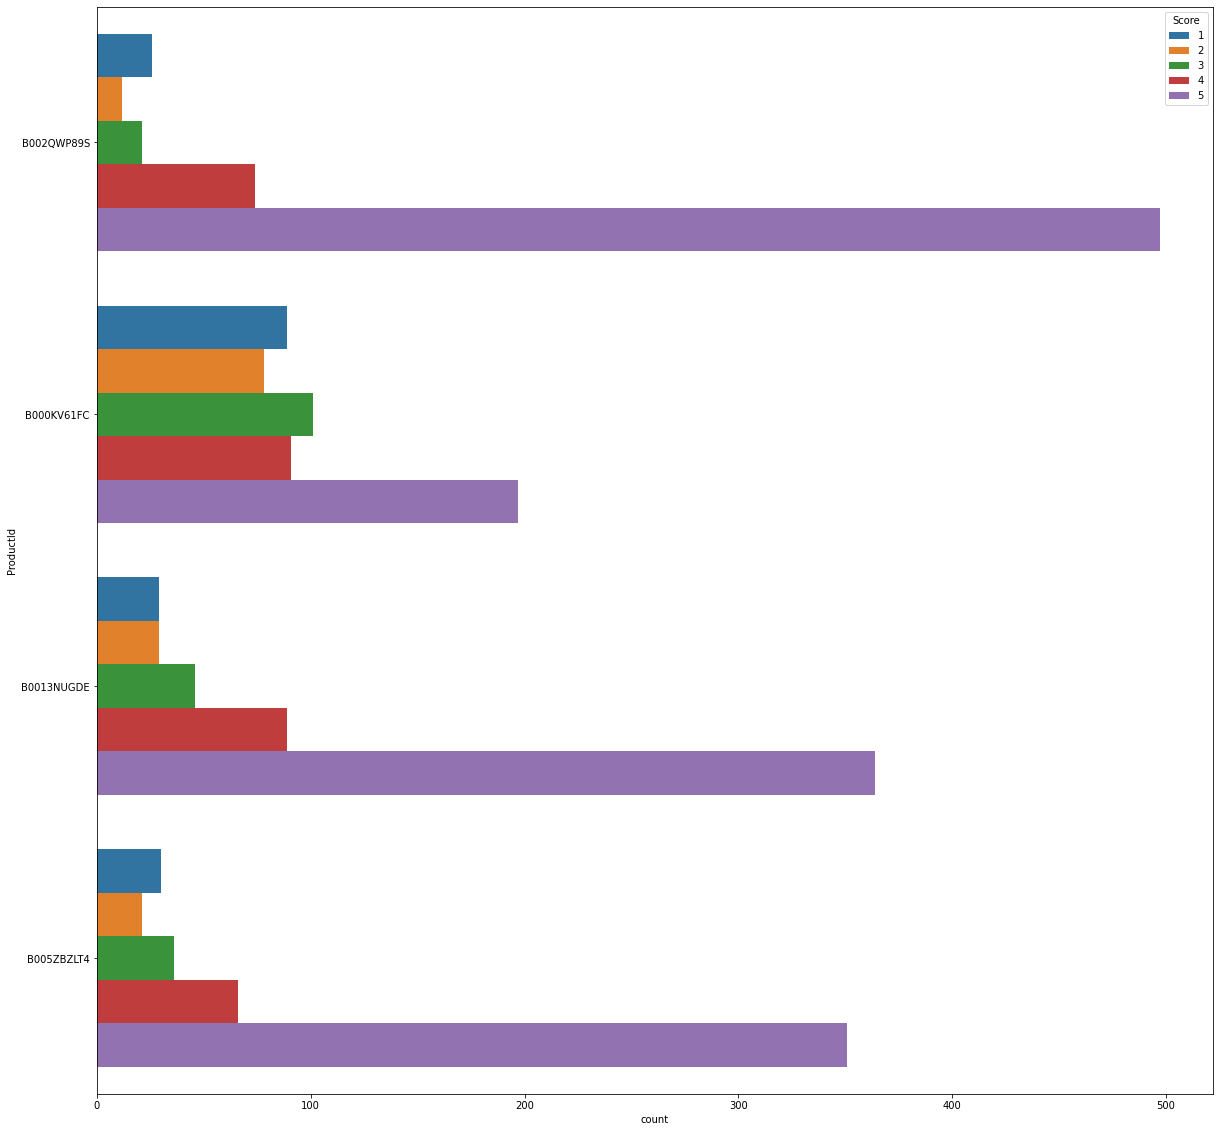

In [13]:
df_products = record.groupby('ProductId').filter(lambda x: len(x) >= 500)
df_product_groups = df_products.groupby('ProductId')
plt.figure(figsize=(20,20))
sns.countplot(y="ProductId",  hue="Score", data=df_products);

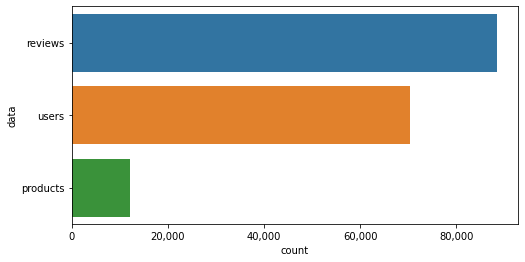

In [14]:
numUsers = len(record['UserId'].unique())
numProducts = len(record['ProductId'].unique())

fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
sns.barplot(data=pd.DataFrame({
    'data': ['reviews', 'users', 'products'],
    'count': [len(record), numUsers, numProducts],
}), x='count', y='data', ax=axes)

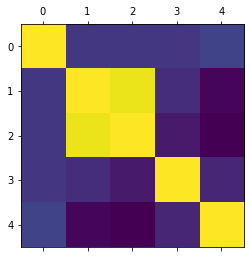

1->id,2->Helpfulnesnumerator,3->heplfullnessdenominator,4->Score,5->Time


In [15]:
plt.matshow(record.corr())
plt.show()
print("1->id,2->Helpfulnesnumerator,3->heplfullnessdenominator,4->Score,5->Time")

In [16]:
f_id=''
drive_file = drive.CreateFile({'id': f_id})
drive_file = drive.CreateFile({'id':'1Zo4obQw8oAiXFcRrRrWoIkxl65CgXen-'}) #file_id to mount
drive_file.GetContentFile('end_words.txt') #getfile

com_list1 = pd.read_csv('end_words.txt')
com_list1 = list(com_list1['e_words'])
print(com_list1)
com_list2 = list(map(lambda element: element.capitalize(), com_list1))
com_list3 = list(map(lambda element: element.upper(), com_list2))
com_words = com_list1 + com_list2 + com_list3

["ain't", "aren't", "can't", "'cause", "could've", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", "how'd", "how'd'y", "how'll", "how's", "I'd", "I'd've", "I'll", "I'll've", "I'm", "I've", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "isn't", "it'd", "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "mayn't", "might've", "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't", "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't", "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've", "shouldn't", "shouldn't've", "so've", "so's", "this's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's", "here's", "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've", "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've", "when's", "when've", "where'd", "wher

In [17]:
nltk.download('stopwords') #Stopwords
word_s = set(stopwords.words('english')) # Stopwords of english language

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def clean_data(text,num):
    buffer = text.lower()
    buffer = re.sub(r'\([^)]*\)', '', buffer) #removing unnecessary datas
    buffer = re.sub('"','', buffer) # clearing double quotes 
    buffer = re.sub("[^a-zA-Z]", " ", buffer) #special characters removed
    buffer = re.sub('[m]{2,}', 'mm', buffer) # remove repeating words
    buffer = BeautifulSoup(buffer, "lxml").text # Handling XML and HTML related datas by converting to text

    if(num==0):
        tokens = [w for w in buffer.split() if not w in word_s] #first cleanup removing stowords
    else:
        tokens=buffer.split() #second cleanup seperating them
        
    long_words=[]
    for i in tokens:
        if len(i)>1:                                               
            long_words.append(i) #records having more than 1 words still
    return (" ".join(long_words)).strip()

In [19]:
processed_data = [] # processed text
for i in com_words:
    if i in record['Text']:
      index = record.index(i)
      record[index] = "" 
for temo in record['Text']:
    processed_data.append(clean_data(temo,0)) # List appending

In [20]:
processed_data[:10]  # Top 10 text datas

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband l

In [21]:
summary_data = [] # processed summary
for i in com_words:
    if i in record['Summary']:
      index = record.index(i)
      record[index] = "" 
for temp in record['Summary']:
    summary_data.append(clean_data(temp,1)) # List appending

In [22]:
summary_data[:10] # Top 10 summary datas

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [23]:
record['processed_data']=processed_data
record['summary_data']=summary_data

In [24]:
record.replace('', np.nan, inplace=True) # remove NaN values,not a proper number
record.dropna(axis=0,inplace=True) # remove Null values

       text
0        23
1        18
2        39
3        17
4        13
...     ...
88346     7
88347    87
88348    20
88349    28
88350    22

[88351 rows x 1 columns]


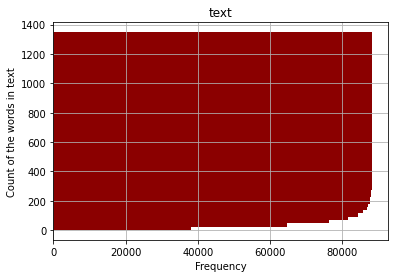

In [26]:
# Array initialization
temp1 = []

for cnts in record['processed_data']:
      temp1.append(len(cnts.split())) # split and append

data_len = pd.DataFrame({'text':temp1}) # Dataframe conversion
print(data_len)
data_len.hist(bins = 60,orientation="horizontal",cumulative=True,color="DarkRed", label="Group 2")
plt.ylabel('Count of the words in text')
plt.xlabel('Frequency')
plt.show() # Outputs the graph

       Feedback_sum
0                 4
1                 3
2                 4
3                 2
4                 2
...             ...
88346             1
88347             3
88348             2
88349             1
88350            12

[88351 rows x 1 columns]


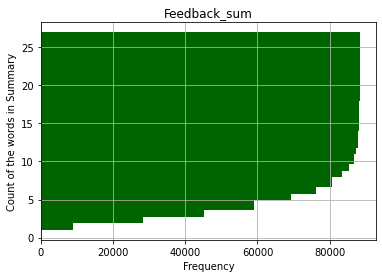

In [27]:
# word count graph for summary
temp2 = []

for cnts in record['summary_data']:
      temp2.append(len(cnts.split())) # List append

data_len = pd.DataFrame({'Feedback_sum':temp2}) # two-dimensional size-mutable, heterogeneous tabular data structure for further and easier calclulations with the data
print(data_len)
data_len.hist(bins = 60,orientation="horizontal",cumulative=True,color="DarkGreen", label="Group 2") # number of histogram bins to display to make th graph clear to understand
plt.ylabel('Count of the words in Summary')
plt.xlabel('Frequency')
plt.show() # Outputs the graph

In [28]:
# Array initializatiomn
txt_array=[]
sum_array=[]

MAX_T_L=50 #Limiting max legth of the text to 30
MAX_S_L=6  #Limiting max legth of the tsummary to 8

In [29]:
processed_data=np.array(record['processed_data']) #numpy conversion for array of text records
summary_data=np.array(record['summary_data']) #numpy conversion for array of summary records

for cnts in range(len(processed_data)):
    if(len(processed_data[cnts].split())<=MAX_T_L and len(summary_data[cnts].split())<=MAX_S_L): #condition check if the data falls below the Max range category
        txt_array.append(processed_data[cnts]) # text appending to array
        sum_array.append(summary_data[cnts]) # summary appending to array
        
Panda_data=pd.DataFrame({'text':txt_array,'summary':sum_array}) #panda conversion dor dataframe

In [30]:
Panda_data['summary'] = Panda_data['summary'].apply(lambda x : 'sostok '+ x + ' eostok') # x = 'sostok '+ x + ' eostok' sentinalvalue

In [31]:
train_x,value_x,train_y,value_y=tts(np.array(Panda_data['text']),np.array(Panda_data['summary']),test_size=0.1,random_state=0,shuffle=True) 
# train_x for tex
# train_y for summary

In [32]:
dx_tok = Tokenizer()  # tokenizer initiallization
dx_tok.fit_on_texts(list(train_x)) # Updates internal vocabulary based on a list of texts

In [33]:
# Check rare elements try 1
escape_val=4 # max number of 4 repeats allowed for texts
# 4 is taken becus text is big compared to summary and can have many repeating words
# declaring variables
counter=0
total_counter=0

In [35]:
for x,y in dx_tok.word_counts.items():
    total_counter=total_counter+1 # number of words in text data ->distinct words
    if(y<escape_val): # if word count freq < 4
        counter=counter+1 # summary with rare text
    
print("% of rare words in data:",(counter/total_counter)*100)
print(counter)
print(total_counter)

% of rare words in data: 63.51989647363313
39268
61820


In [37]:
tokens_x = Tokenizer(num_words=total_counter-counter)  # tokenizer initiallization
tokens_x.fit_on_texts(list(train_x)) # Updates internal vocabulary based on a list of texts

value_x_seq = tokens_x.texts_to_sequences(value_x) # Transforms each text in texts to a sequence of integers from word_index dictionary
value_x = pad_sequences(value_x_seq, maxlen=MAX_T_L, padding='post') # checks if all records in the list are of same size or it apends 0 post the given record untill it matches MAX_T_L

train_x_seq = tokens_x.texts_to_sequences(train_x) # Transforms each text in texts to a sequence of integers from word_index dictionary
train_x = pad_sequences(train_x_seq, maxlen=MAX_T_L, padding='post') # checks if all records in the list are of same size or it apends 0 post the given record untill it matches MAX_T_L

final_x = tokens_x.num_words + 1 # Total words in the record +1 for NULL

In [38]:
final_x # Total text word count -> distinct words in text

22553

In [39]:
# allows to vectorize a text corpus, by turning each text into a vector where the coefficient for each token is based on word count
tokens_y = Tokenizer()   
tokens_y.fit_on_texts(list(train_y)) # Updates internal vocabulary based on a list of texts

In [40]:
# Check rare elements try 2
escape_val=6  # max number of 6 repeats of word allowed throughout the file for summary
# 6 is taken as summary data is already minimized from data preprocessing
# declaring variables
counter=0
total_counter=0

In [41]:
for x,y in tokens_y.word_counts.items():
    total_counter=total_counter+1 # number of words in summary data ->distinct words
    if(y<escape_val):
        counter=counter+1 # rare words count -> distinct rare words
        
print("% of rare words in data:",(counter/total_counter)*100)

% of rare words in data: 77.59557539297496


In [42]:
tokens_y = Tokenizer(num_words=total_counter-counter) # tokenizer initiallization
tokens_y.fit_on_texts(list(train_y)) # Updates internal vocabulary based on a list of texts

train_y_seq    =   tokens_y.texts_to_sequences(train_y) # Transforms each text in texts to a sequence of integers from word_index dictionary
train_y    =   pad_sequences(train_y_seq, maxlen=MAX_S_L, padding='post') # checks if all records in the list are of same size or it apends 0 post the given record untill it matches MAX_T_L

value_y_seq   =   tokens_y.texts_to_sequences(value_y) # Transforms each text in texts to a sequence of integers from word_index dictionary
value_y   =   pad_sequences(value_y_seq, maxlen=MAX_S_L, padding='post') # checks if all records in the list are of same size or it apends 0 post the given record untill it matches MAX_T_L

final_y  =   tokens_y.num_words +1 # Total words in the record +1 for NULL

In [45]:
final_y # Total summary word count -> distinct words in summary

2310

In [46]:
tokens_y.word_counts['sostok'],len(train_y) # Total words read in Summary (Repetition allowed) is equal to summary dataset length
# The correctness of model evaluated here

(54747, 54747)

In [47]:
cache=[] # Array initialization
for l in range(len(train_y)): # Runs every record as a sentence summary
    count=0
    for k in train_y[l]: # checks for every word in a sentence
        if k!=0:
            count=count+1 # cnt increases
    if(count==2):
        cache.append(l) # append the value to cache

In [48]:
train_y=np.delete(train_y,cache, axis=0) # Cache removed from axis 0 in Summary
train_x=np.delete(train_x,cache, axis=0) # Cache removed from axis 0 in Texts

In [49]:
# Now since it's removed from dataset it must be removed from value also, failing to do this may result in data inconsistency
# As a data shown in value_x and y may not be actually available in the data set

cache=[] # Array initialization
for i in range(len(value_y)): # Runs every index of the record
    count=0
    for j in value_y[i]: # checks element in the row
        if j!=0:
            count=count+1 # cnt increases
    if(count==2):
        cache.append(i) # append the value to cache

# As seen from the graph there is a steep increase in the word count for 2, which slows down the process, hence it's removed

In [50]:
value_y=np.delete(value_y,cache, axis=0) # Cache removed from axis 0 in Summary
value_x=np.delete(value_x,cache, axis=0) # Cache removed from axis 0 in Texts

# Now even though removed sepreately both should be in sync

# Model building


Why LSTM?

Long Short-Term Memory (LSTM) networks can convey information in the long term. Different from the traditional RNN, inside each LSTM cell, there are several simple linear operations which allow data to be conveyed without doing the complex computation.

In [51]:
# Layers -> “forget gate layer”, “input gate layer”, “output gate layer”

# Forget Gate Layer

#Input Gate Layer
#Outputs a number to indicate inside which cells the information should be updated

# Output Gate Layer
# process occuring -> In the cell state is going through a tanh function, and then it is multiplied by the weighted output of the sigmoid function. 

# Keras for Attention Layer Support in tensorflow
from keras import backend as Back 
Back.clear_session()

facet_a=300 # Latent Dimension -> input data for every iteration
facet_e=100
# Embedding Dimension -> Result data gathered from every iteration to be sent to next iteration
#higher number, the network gets more powerful. Howevery, the number of parameters to learn also rises. This means it needs more time to train the network.

podium_i=Input(shape=(MAX_T_L,))
# Word embedding is a set of feature learning techniques in NLP where words are mapped to vectors of real numbers.
coll_d=Embedding(final_x, facet_e,trainable=True)(podium_i)

# 0 means do not let any information pass, while 1 means let all information pass

# Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
# This leads to a better representation of the sequence.

# stack 1 LSTM
answer_a=LSTM(facet_a, 
              dropout=0.4, # Attention paid to all the data elements during this iteartion
              return_sequences=True, # LSTM produces the hidden state and cell state for every timestep  
              recurrent_dropout=0.4, # Attention paid to input data
              return_state=True) 
r1,tell1,tell2=answer_a(coll_d)

# stack 2 LSTM
answer_b=LSTM(facet_a, 
              dropout=0.4, # Attention paid to all the data elements during this iteartion
              return_sequences=True,  # LSTM produces the hidden state and cell state for every timestep
              recurrent_dropout=0.4, # Attention paid to the before result iteration
              return_state=True)
r2,m2,m3=answer_b(r1)

# stack 3 LSTM
answer_c=LSTM(facet_a, 
              dropout=0.4, # Attention paid to all the data elements during this iteartion
              return_sequences=True,  # LSTM produces the hidden state and cell state for every timestep
              recurrent_dropout=0.4, # Attention paid to the before result iteration
              return_state=True)
eye_e,item_a,item_b=answer_c(r2)
# All information is passed through all the cells while the critical information is kept to the end, no matter how many cells the network has.


ins_datum=Input(shape=(None,))
# builds a relationship between words and allows calculations among them
# Eg:- “king - men + women” = “queen”
stack_e=Embedding(final_y, facet_e,trainable=True)
podium_d=stack_e(ins_datum)

#Final LSTM Decoding for biderectional check
dmodule=LSTM(facet_a, 
              dropout=0.4, # Attention paid to all the data elements during this iteartion
              return_sequences=True,  # LSTM produces the hidden state and cell state for every timestep
              recurrent_dropout=0.2, # Attention paid to the before result iteration
              return_state=True)

# Initializing it to a value
eye_d,decoder_fwd_state, decoder_back_state=dmodule(podium_d,initial_state=[item_a, item_b])

# Attention Layer Object
object_m=Algo_attention(name='Algorithm_attention')
# check
attn_out, attn_states = object_m([eye_e, eye_d])

# Concatinating
podium_dec_i=Concatenate(axis=-1, name='concat_layer')([eye_d, attn_out])

# wrapper allows to apply a layer to every temporal slice of an input
# Activation is the element-wise activation function
# Softmax converts a real vector to a vector of categorical probabilities, cuz max of (a)t is 1
# final_y is the feauture vector with both encoder and decoder data
strcpy_p=TimeDistributed(Dense(final_y, activation='softmax'))

# making a dense cluster
eye_d=strcpy_p(podium_dec_i)

#Model creation
blue_p=Model([podium_i, ins_datum],eye_d)

In [52]:
#Config the model with losses and metrics
blue_p.compile(loss='sparse_categorical_crossentropy', #Sparse categorical crossentropy loss value.
               optimizer='rmsprop') #Optimizer that implements the RMSprop algorithm.

In [ ]:
# Early stopping is a technique used to terminate the training before overfitting occurs
Stope = EarlyStopping(mode='min', # Terminates when quantity monitored has stopped decreasing;
                      patience=2, # Terminates if no improvement found for 2 consequtive epochs
                      verbose=1, # Output messages which could be useful for debugging
                      monitor='val_loss') #Quantity to be monitored for debugging

In [ ]:
# Train and validate model by fitting
wetrain=blue_p.fit([train_x, # initial text data
                    train_y[:,:-1]],  # removes last char
                    train_y.reshape(train_y.shape[0], # Processed data of summary
                    train_y.shape[1], 1)[:,1:], 
                    callbacks=[Stope],  # Early stopping
                    batch_size=128, # Since large dataset, it's set to 128 instead of default 32 
                    epochs=10, # Refning the model, generally defined as "one pass over the entire dataset". Larger the epoch better refined is the model 
                    # validating dataset where the model will not be trained
                    validation_data=([value_x,value_y[:,:-1]], 
                                     value_y.reshape(value_y.shape[0],value_y.shape[1], 1)[:,1:]))

Epoch 1/10
419/419 [==============================] - 253s 578ms/step - loss: 3.8851 - val_loss: 3.2228
Epoch 2/10
419/419 [==============================] - 240s 574ms/step - loss: 3.1636 - val_loss: 2.9703
Epoch 3/10
419/419 [==============================] - 239s 569ms/step - loss: 2.9548 - val_loss: 2.8406
Epoch 4/10
419/419 [==============================] - 237s 565ms/step - loss: 2.8094 - val_loss: 2.7548
Epoch 5/10
419/419 [==============================] - 239s 570ms/step - loss: 2.7211 - val_loss: 2.7280
Epoch 6/10
419/419 [==============================] - 237s 565ms/step - loss: 2.6376 - val_loss: 2.6618
Epoch 7/10
419/419 [==============================] - 241s 574ms/step - loss: 2.5747 - val_loss: 2.6351
Epoch 8/10
419/419 [==============================] - 238s 567ms/step - loss: 2.5119 - val_loss: 2.6158
Epoch 9/10
419/419 [==============================] - 236s 564ms/step - loss: 2.4699 - val_loss: 2.5860
Epoch 10/10
419/419 [==============================] - 233s 555m

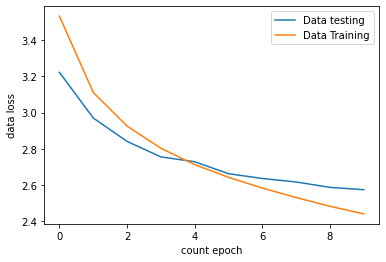

In [ ]:
# Graph to demonstrate the Training vs Testing in the model
from matplotlib import pyplot
plt.ylabel('data loss')
plt.xlabel('count epoch')
# .history is inbuilt model function 
pyplot.plot(wetrain.history['val_loss'], label='Data testing') # Gives how the testing data fared
pyplot.plot(wetrain.history['loss'], label='Data Training') # Gives how the training data fared
pyplot.legend()
pyplot.show()

In [ ]:
# Tokenizer method creates the vocabulary index based on word frequency.
r_aim_wi=tokens_y.index_word # returns the index_word list of token_y which is summary ->reverse
back_data_m=tokens_x.index_word # returns the index_word list of token_x which is texts ->reverse
aim_wi=tokens_y.word_index # returns the word_index list of token_y which is summary ->straight
# Every word gets a unique integer value.So lower integer means more frequent word

In [ ]:
copy_e = Model(inputs=podium_i,outputs=[eye_e, item_a, item_b]) # Creating a model for texts

# facet_a is the size considered for every model in this program
material_d=Input(shape=(facet_a)) # creating tensors of size which is used for all models
material_e=Input(shape=(facet_a)) # creating tensors of size which is used for all models

o_stacke=stack_e(ins_datum) # final LSTM encode data of texts

m1,m2,m3=dmodule(o_stacke, initial_state=[material_d, material_e]) # inputting text data to summary LSTM

material_f = Input(shape=(MAX_T_L,facet_a)) # creating 2d tensors of size which is used for all models with each key size MAX_T_L
o_att, s_att = object_m([material_f, m1]) # Applying Attention layer result

joined_data = Concatenate(axis=-1, name='concat')([m1, o_att]) # concattinnating LSTM res with Attention layer
m1 = strcpy_p(joined_data) # dense cluster 

copy_d = Model([ins_datum]+[material_f,material_d, material_e],[m1]+[m2, m3]) # Final model creation for summary abstraction

In [ ]:
def sum_conv(blob):
    vault='' # Empty string
    for kval in blob:
        if((kval!=aim_wi['sostok']) and kval!=aim_wi['eostok'] and kval!=0): # if the data is not equal to the two sentimental value given
            vault=vault+r_aim_wi[kval]+' '  # Appending data to vault
    return vault

In [ ]:
def crackit(blob):
    result_buff='' # Empty string
    flag=False # bool flag
    crux_data=np.zeros((1,1)) # zero array
    crux_data[0, 0]=aim_wi['sostok'] # inititaling the first data
    t1,t2,t3=copy_e.predict(blob) # predict from text model of LSTM
    while not flag:
        result_tok,po,lo=copy_d.predict([crux_data]+[t1,t2,t3]) # predict from final model for summary of LSTM
        tok_pointer=np.argmax(result_tok[0, -1, :]) # Returns indices of the max element of the array in a particular axis
        coupon=r_aim_wi[tok_pointer] # Appending max data index to coupon
        if (coupon=='eostok' or len(result_buff.split())>=(MAX_S_L-1)):
            flag=True # breaks at the end ot at (time when max summary length is increasing at hits 7) extra echeck done
        if (coupon!='eostok'): # if not the sentimental value then add
            result_buff+=' '+coupon # append data
        t2,t3=po,lo # overwritting the text predict
        crux_data=np.zeros((1,1)) # re initializing to 0 to save space
        crux_data[0,0]=tok_pointer #max_element index

    return result_buff

In [ ]:
def txt_conv(blob):
    vault='' # empty string
    for kval in blob:
        if(kval!=0): # if not empty(NUll or 0)
            vault=vault+back_data_m[kval]+' ' #Appending data
    return vault

In [ ]:
# Result dictionary
LSTM_RES = {
              "Feedback": [],
              "Real Result": [],
              "Predicted Result": []
}
for i in range(0,10): # top 10 printing
    print("Feedback:",txt_conv(train_x[i])) # Review text
    LSTM_RES['Feedback'].append(txt_conv(train_x[i]))
    print("Real Result:",sum_conv(train_y[i])) # Original summary
    LSTM_RES['Real Result'].append(sum_conv(train_y[i]))
    print("Predicted Result:",crackit(train_x[i].reshape(1,MAX_T_L))) # Predicted Summary
    LSTM_RES['Predicted Result'].append(crackit(train_x[i].reshape(1,MAX_T_L)))
    print("\n")

Feedback: advised receive box less local grocery store purchase 
Real Result: misleading 
Predicted Result:  great


Feedback: love fortune cookies broken box buy 
Real Result: loved them 
Predicted Result:  cookies


Feedback: tea tastes great really works help like relax fall asleep recommend half hour hour bedtime 
Real Result: great for relaxing into 
Predicted Result:  great tea


Feedback: wonderful oil leaves taste oil cooks great actually good br used frying works great dressings favorite oil 
Real Result: great oil 
Predicted Result:  great product


Feedback: though coffee expensive compared regular store bought huge fan coffee usually tears stomach tea drinker years coffee low acidic level handle aroma enticing bag lasted long time fan beans versus grounds another plus prompt packaging coffee stayed fresh intact 
Real Result: great buy 
Predicted Result:  great tasting


Feedback: cookies best store bought cookies ever eaten usually prefer cookies product superb fine enough 

Further research using this would be to predict the stars that the review would have got with just texts given.

This model is also used to redict the caption of the image by just focusssing on one part og it just like humans